# Import Library

In [1]:
# ===============================
# BBCA Stock Forecasting Pipeline
# Data: 2023-01-01 until 2025-09-09
# LSTM
# ===============================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data Acquisition

In [2]:
# -------------------------------
# 1. Data Acquisition
# -------------------------------
bbca = yf.download("BBCA.JK", start="2023-01-01", end="2025-09-09", interval="1d")
bbca.dropna(inplace=True)

# flatten multiindex columns if exists
if isinstance(bbca.columns, pd.MultiIndex):
    bbca.columns = bbca.columns.get_level_values(0)

C:\Users\poj00\AppData\Local\Temp\ipykernel_6172\3322784905.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbca = yf.download("BBCA.JK", start="2023-01-01", end="2025-09-09", interval="1d")
[*********************100%***********************]  1 of 1 completed


# Feature Engineering

In [3]:
# -------------------------------
# 2. Daily Return (Target Variable)
# -------------------------------
bbca["DR"] = 100 * (bbca["Close"] - bbca["Open"]) / bbca["Open"]

In [4]:
# -------------------------------
# 3. Technical Indicators
# -------------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window=window, min_periods=1).mean()
    ma_down = down.rolling(window=window, min_periods=1).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_atr(high, low, close, window=14):
    prev_close = close.shift(1)
    tr = pd.concat([
        (high - low).abs(),
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=window, min_periods=1).mean()


def compute_ao(close, short=5, long=34):
    sma_short = close.rolling(window=short, min_periods=1).mean()
    sma_long = close.rolling(window=long, min_periods=1).mean()
    return sma_short - sma_long

def compute_adx(high, low, close, window=14):
    # True Range components
    plus_dm = high.diff()
    minus_dm = low.diff() * -1

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0

    tr1 = (high - low).abs()
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.rolling(window=window, min_periods=1).mean()

    plus_di = 100 * (plus_dm.rolling(window=window, min_periods=1).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=window, min_periods=1).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di + 1e-9)) * 100
    adx = dx.rolling(window=window, min_periods=1).mean()

    return adx


def compute_aroon(high, low, window=25):
    # Aroon Up
    rolling_high_idx = high.rolling(window=window, min_periods=1).apply(lambda x: x.argmax(), raw=True)
    aroon_up = 100 * ((window - rolling_high_idx) / window)

    # Aroon Down
    rolling_low_idx = low.rolling(window=window, min_periods=1).apply(lambda x: x.argmin(), raw=True)
    aroon_down = 100 * ((window - rolling_low_idx) / window)

    # Aroon Oscillator (Up - Down)
    aroon_osc = aroon_up - aroon_down
    return aroon_osc


In [5]:
bbca["RSI"] = compute_rsi(bbca["Close"], 14)
bbca["ATR"] = compute_atr(bbca["High"], bbca["Low"], bbca["Close"], 14)
bbca["AO"]  = compute_ao(bbca["Close"], 5, 34)
bbca["ADX"] = compute_adx(bbca["High"], bbca["Low"], bbca["Close"], 14)
bbca["AI"]  = compute_aroon(bbca["High"], bbca["Low"], 25)

In [6]:
# -------------------------------
# 4. Seasonality Features
# -------------------------------
bbca["dow"] = bbca.index.dayofweek
bbca["month"] = bbca.index.month
dow = pd.get_dummies(bbca["dow"], prefix="dow")
month = pd.get_dummies(bbca["month"], prefix="m")
bbca = bbca.join(dow).join(month)

In [7]:
# -------------------------------
# 5. Dummy Sentiment / News
# -------------------------------
sentiment = np.sign(bbca["DR"].shift(1).fillna(0))
sentiment = sentiment + np.random.normal(scale=0.2, size=len(sentiment))
bbca["sentiment"] = np.clip(sentiment, -1, 1)
bbca["news_count"] = np.random.poisson(lam=2.0, size=len(bbca))

In [8]:
# -------------------------------
# 6. Final Dataset
# -------------------------------
bbca = bbca.dropna()

feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "RSI", "ATR", "AO", "ADX", "AI",
                "sentiment", "news_count"] \
               + list(dow.columns) + list(month.columns)
bbca.head()

,Close,High,Low,Open,Volume,DR,RSI,ATR,AO,ADX,...,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,sentiment,news_count
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,7872.041992,7918.077325,7849.024326,7872.041992,27399100,0.000000,0.000000,80.561833,0.000000,0.000000,...,False,False,False,False,False,False,False,False,-1.000000,2
2023-01-04,7687.900879,7895.059885,7687.900879,7849.024550,90918800,-2.052786,0.000000,122.760891,0.000000,50.000000,...,False,False,False,False,False,False,False,False,-0.316286,2
2023-01-05,7595.830078,7710.918413,7503.759411,7687.900746,128838500,-1.197605,0.000000,143.860419,0.000000,66.666667,...,False,False,False,False,False,False,False,False,-1.000000,2
2023-01-06,7641.865723,7664.883390,7457.724380,7457.724380,69286600,2.469136,14.285801,156.520137,0.000000,75.000000,...,False,False,False,False,False,False,False,False,-0.842861,2
2023-01-09,7779.970703,7779.970703,7664.882379,7664.882379,86916900,1.501502,39.999915,153.450944,-26.086686,70.909146,...,False,False,False,False,False,False,False,False,0.964476,2


In [9]:
# -------------------------------
# 7. Sequence Preparation
# -------------------------------
WINDOW = 3
X, y, dates = [], [], []

vals = bbca[feature_cols].values
dr_vals = bbca["DR"].values

for i in range(WINDOW, len(bbca)):
    X.append(vals[i-WINDOW:i])  # 3 hari sebelumnya
    y.append(dr_vals[i])        # return besok
    dates.append(bbca.index[i])

X = np.array(X)
y = np.array(y)

In [10]:
# -------------------------------
# 8. Dataset Splitting
# -------------------------------
# validation = last 140 trading days before test period
# test = last 70 trading days (May–Sep 2025)
# train = from start until ~ last 2024

test_size = 70
val_size = 140
total = len(X)

X_train = X[:-(val_size+test_size)]
y_train = y[:-(val_size+test_size)]
dates_train = dates[:-(val_size+test_size)]

X_val = X[-(val_size+test_size):-test_size]
y_val = y[-(val_size+test_size):-test_size]
dates_val = dates[-(val_size+test_size):-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]
dates_test = dates[-test_size:]

In [11]:
# -------------------------------
# 9. Scaling
# -------------------------------
scaler = StandardScaler()
nsamples, nsteps, nfeatures = X_train.shape
X_train_s = scaler.fit_transform(X_train.reshape(-1, nfeatures)).reshape(X_train.shape)
X_val_s   = scaler.transform(X_val.reshape(-1, nfeatures)).reshape(X_val.shape)
X_test_s  = scaler.transform(X_test.reshape(-1, nfeatures)).reshape(X_test.shape)

# Model

In [20]:
# -------------------------------
# 10. LSTM Model
# -------------------------------
tf.random.set_seed(42)

model = Sequential([
    LSTM(128, input_shape=(WINDOW, nfeatures), activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="linear")
])

model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
history = model.fit(X_train_s, y_train,
                    validation_data=(X_val_s, y_val),
                    epochs=250, batch_size=32, verbose=1)


Epoch 1/250
14/14 [==============================] - 2s 36ms/step - loss: 1.1937 - mae: 0.8253 - val_loss: 2.5495 - val_mae: 1.2033
Epoch 2/250
14/14 [==============================] - 0s 6ms/step - loss: 1.1324 - mae: 0.7939 - val_loss: 2.5600 - val_mae: 1.2130
Epoch 3/250
14/14 [==============================] - 0s 12ms/step - loss: 1.0957 - mae: 0.7916 - val_loss: 2.5634 - val_mae: 1.2165
Epoch 4/250
14/14 [==============================] - 0s 7ms/step - loss: 1.0914 - mae: 0.7869 - val_loss: 2.5689 - val_mae: 1.2187
Epoch 5/250
14/14 [==============================] - 0s 5ms/step - loss: 1.0673 - mae: 0.7780 - val_loss: 2.5523 - val_mae: 1.2049
Epoch 6/250
14/14 [==============================] - 0s 7ms/step - loss: 1.0451 - mae: 0.7686 - val_loss: 2.5673 - val_mae: 1.2140
Epoch 7/250
14/14 [==============================] - 0s 5ms/step - loss: 1.0311 - mae: 0.7672 - val_loss: 2.5856 - val_mae: 1.2155
Epoch 8/250
14/14 [==============================] - 0s 5ms/step - loss: 1.0124 -

# Predictions

In [21]:
# -------------------------------
# 11. Predictions
# -------------------------------
y_pred = model.predict(X_test_s).flatten()

results = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_pred
}).set_index("date")

results.head()

3/3 [==============================] - 0s 4ms/step


,true_DR,pred_DR
date,,
2025-05-23,0.000000,1.170002
2025-05-26,0.260417,0.370451
2025-05-27,-1.047120,1.495104
2025-05-28,-0.529101,-0.132568
2025-06-02,0.831025,2.401618


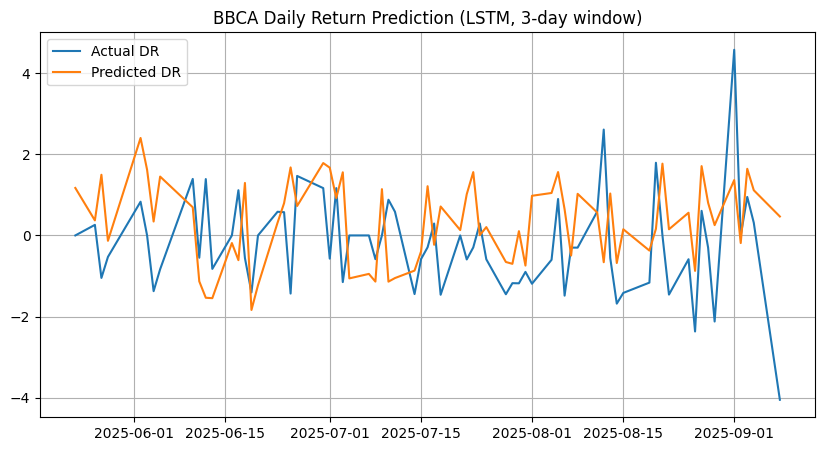

In [22]:
# -------------------------------
# 12. Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(results.index, results["true_DR"], label="Actual DR")
plt.plot(results.index, results["pred_DR"], label="Predicted DR")
plt.legend()
plt.title("BBCA Daily Return Prediction (LSTM, 3-day window)")
plt.grid(True)
plt.show()

# Evaluations

3/3 [==============================] - 0s 1ms/step


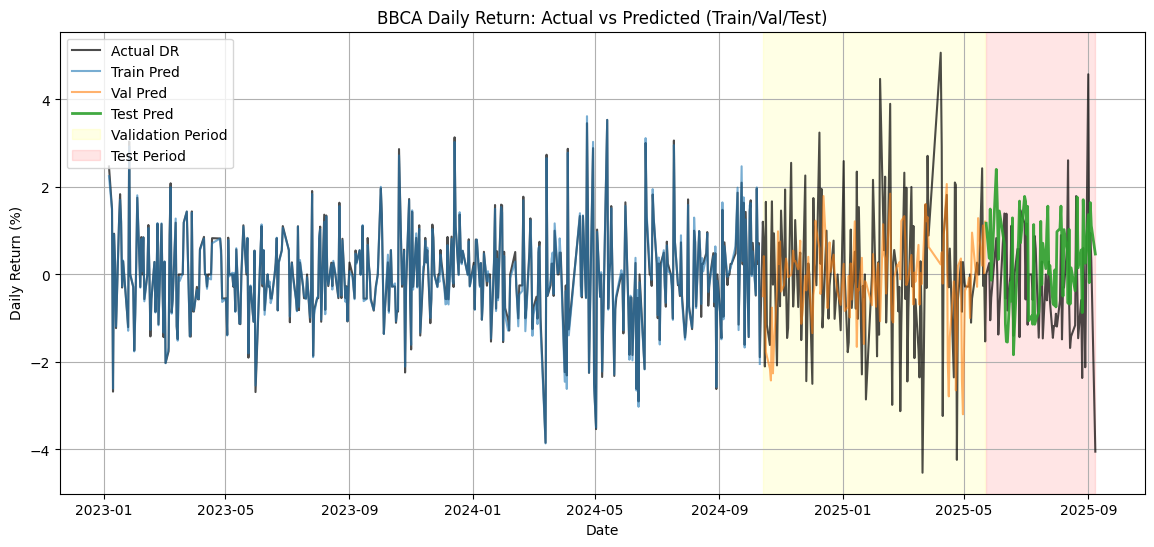

In [23]:
# -------------------------------
# 13. Predict on all splits
# -------------------------------
y_train_pred = model.predict(X_train_s).flatten()
y_val_pred   = model.predict(X_val_s).flatten()
y_test_pred  = model.predict(X_test_s).flatten()

# merge
df_train = pd.DataFrame({
    "date": dates_train,
    "true_DR": y_train,
    "pred_DR": y_train_pred,
    "set": "train"
})

df_val = pd.DataFrame({
    "date": dates_val,
    "true_DR": y_val,
    "pred_DR": y_val_pred,
    "set": "val"
})

df_test = pd.DataFrame({
    "date": dates_test,
    "true_DR": y_test,
    "pred_DR": y_test_pred,
    "set": "test"
})

results_all = pd.concat([df_train, df_val, df_test]).set_index("date")

# -------------------------------
# 14. Visualization (all data)
# -------------------------------
plt.figure(figsize=(14,6))
plt.plot(results_all.index, results_all["true_DR"], label="Actual DR", color="black", alpha=0.7)

# plot the merged data
plt.plot(df_train["date"], df_train["pred_DR"], label="Train Pred", alpha=0.6)
plt.plot(df_val["date"], df_val["pred_DR"], label="Val Pred", alpha=0.6)
plt.plot(df_test["date"], df_test["pred_DR"], label="Test Pred", alpha=0.9, linewidth=2)

plt.axvspan(df_val["date"].iloc[0], df_val["date"].iloc[-1], color="yellow", alpha=0.1, label="Validation Period")
plt.axvspan(df_test["date"].iloc[0], df_test["date"].iloc[-1], color="red", alpha=0.1, label="Test Period")

plt.title("BBCA Daily Return: Actual vs Predicted (Train/Val/Test)")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_metrics(y_true, y_pred, eps=1e-8):
    """
    Returns: (mae, mape_percent, rmse)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # tanpa arg squared
    rmse = np.sqrt(mse)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    return mae, mse, rmse, mape

def direction_accuracy(y_true, y_pred):
    s_true = np.sign(y_true)
    s_pred = np.sign(y_pred)
    return 100.0 * np.mean(s_true == s_pred)

# --- compute metrics for each split ---
mae_train, mse_train, rmse_train, mape_train = evaluate_metrics(y_train, y_train_pred)
mae_val, mse_val, rmse_val, mape_val   = evaluate_metrics(y_val, y_val_pred)
mae_test, mse_test, rmse_test, mape_test  = evaluate_metrics(y_test, y_test_pred)

acc_dir_train = direction_accuracy(y_train, y_train_pred)
acc_dir_val   = direction_accuracy(y_val, y_val_pred)
acc_dir_test  = direction_accuracy(y_test, y_test_pred)

# --- print results ---
print("Performance Metrics:")
print(f"Train -> MAE: {mae_train:.4f}, MSE: {mse_train}, MAPE: {mape_train}, RMSE: {rmse_train:.4f}, DirAcc: {acc_dir_train:.2f}%")
print(f"Val   -> MAE: {mae_val:.4f}, MSE: {mse_val}, MAPE: {mape_val}, RMSE: {rmse_val:.4f}, DirAcc: {acc_dir_val:.2f}%")
print(f"Test  -> MAE: {mae_test:.4f}, MSE: {mse_test}, MAPE: {mape_test}, RMSE: {rmse_test:.4f}, DirAcc: {acc_dir_test:.2f}%")

Performance Metrics:
Train -> MAE: 0.0725, MSE: 0.009456990513562235, MAPE: 86081164.06662458, RMSE: 0.0972, DirAcc: 86.16%
Val   -> MAE: 1.3472, MSE: 2.999822019708545, MAPE: 715455216.7352601, RMSE: 1.7320, DirAcc: 53.57%
Test  -> MAE: 1.2804, MSE: 2.4721204293936085, MAPE: 1348897849.831503, RMSE: 1.5723, DirAcc: 42.86%


In [25]:
# -------------------------------
# Predict newest data (out-of-sample)
# -------------------------------

# 1. Download newest data
new_data = yf.download("BBCA.JK", start="2025-09-01", end="2025-09-20", interval="1d")
if isinstance(new_data.columns, pd.MultiIndex):
    new_data.columns = new_data.columns.get_level_values(0)

# 2. Feature engineering
new_data["DR"] = 100 * (new_data["Close"] - new_data["Open"]) / new_data["Open"]
new_data["RSI"] = compute_rsi(new_data["Close"], 14)
new_data["ATR"] = compute_atr(new_data["High"], new_data["Low"], new_data["Close"], 14)
new_data["AO"]  = compute_ao(new_data["Close"], 5, 34)
new_data["ADX"] = compute_adx(new_data["High"], new_data["Low"], new_data["Close"], 14)
new_data["AI"]  = compute_aroon(new_data["High"], new_data["Low"], 25)
new_data["dow"] = new_data.index.dayofweek
new_data["month"] = new_data.index.month

dow_new = pd.get_dummies(new_data["dow"], prefix="dow")
month_new = pd.get_dummies(new_data["month"], prefix="m")

# reindex supaya sama dengan training
dow_new = dow_new.reindex(columns=[c for c in feature_cols if c.startswith("dow_")], fill_value=0)
month_new = month_new.reindex(columns=[c for c in feature_cols if c.startswith("m_")], fill_value=0)

new_data = new_data.join(dow_new).join(month_new)

# Dummy sentiment & news count
sentiment = np.sign(new_data["DR"].shift(1).fillna(0))
sentiment = sentiment + np.random.normal(scale=0.2, size=len(sentiment))
new_data["sentiment"] = np.clip(sentiment, -1, 1)
new_data["news_count"] = np.random.poisson(lam=2.0, size=len(new_data))

new_data = new_data.dropna()

# 3. Buat window 3 hari untuk prediksi DR
vals_new = new_data[feature_cols].values
dr_vals_new = new_data["DR"].values
dates_new = new_data.index

X_new, y_new, d_new = [], [], []
for i in range(WINDOW, len(new_data)):
    X_new.append(vals_new[i-WINDOW:i])
    y_new.append(dr_vals_new[i])
    d_new.append(dates_new[i])

X_new = np.array(X_new)
y_new = np.array(y_new)

# 4. Scale dan prediksi
X_new_s = scaler.transform(X_new.reshape(-1, nfeatures)).reshape(X_new.shape)
y_new_pred = model.predict(X_new_s).flatten()

# 5. Bandingkan hasil prediksi vs aktual
comparison = pd.DataFrame({
    "date": d_new,
    "true_DR": y_new,
    "pred_DR": y_new_pred
}).set_index("date")

# filter hanya tanggal 10-19 September 2025
print(comparison.loc["2025-09-10":"2025-09-19"])

C:\Users\poj00\AppData\Local\Temp\ipykernel_6172\764460007.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_data = yf.download("BBCA.JK", start="2025-09-01", end="2025-09-20", interval="1d")
[*********************100%***********************]  1 of 1 completed

1/1 [==============================] - 0s 39ms/step
             true_DR   pred_DR
date                          
2025-09-10  3.311258  0.529806
2025-09-11 -0.632911  0.036225
2025-09-12 -0.626959  0.001933
2025-09-15  0.312500 -0.144105
2025-09-16 -1.552795 -0.181151
2025-09-17  0.000000  0.078433
2025-09-18 -1.910828  0.516265
2025-09-19  1.960784 -0.065404


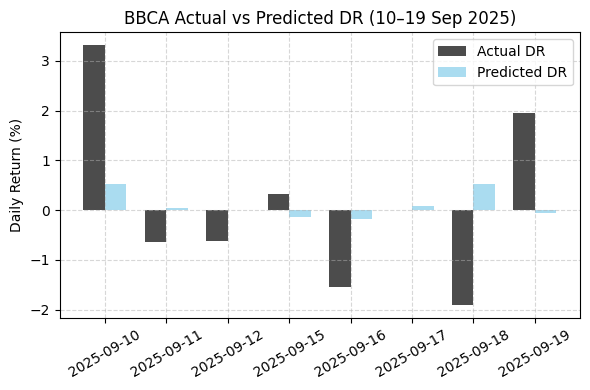

In [26]:
# -------------------------------
# Mini Visualization (10-19 Sep 2025)
# -------------------------------
subset = comparison.loc["2025-09-10":"2025-09-19"]

plt.figure(figsize=(6,4))
width = 0.35
x = np.arange(len(subset))

plt.bar(x - width/2, subset["true_DR"], width, label="Actual DR", color="black", alpha=0.7)
plt.bar(x + width/2, subset["pred_DR"], width, label="Predicted DR", color="skyblue", alpha=0.7)

plt.xticks(x, [d.strftime("%Y-%m-%d") for d in subset.index], rotation=30)
plt.ylabel("Daily Return (%)")
plt.title("BBCA Actual vs Predicted DR (10–19 Sep 2025)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()